In [ ]:
import pdb;
import os
import re
import time
import torch
import PIL.Image as Image

torch.backends.cuda.enable_mem_efficient_sdp(False)
torch.backends.cuda.enable_flash_sdp(False)

In [5]:
from qwen_vl_utils import process_vision_info
from model.showui.processing_showui import ShowUIProcessor
from model.showui.modeling_showui import ShowUIForConditionalGeneration

### ShowUI Preprocessor
# 0. Common setups
min_pixels = 256*28*28
max_pixels = 1344*28*28
# 1. Screenshot -> Graph
uigraph_train = True        # Enable ui graph during training
uigraph_test = True         # Enable ui graph during inference
uigraph_diff = 1            # Pixel difference used for constructing ui graph
uigraph_rand = False        # Enable random graph construction 
# 2. Graph -> Mask 
uimask_pre = True           # Prebuild patch selection mask in the preprocessor (not in model layers) for efficiency
uimask_ratio = 0.5          # Specify the percentage of patch tokens to skip per component
uimask_rand = False         # Enable random token selection instead of uniform selection

### ShowUI Model
lm_skip_ratio = uimask_ratio # valid if not uimask_pre
lm_skip_layer = "[1,28,1]"   # [1,28,1] means we apply UI guide token selection from 1-th to 28-th layer (28 is the last layer of Qwen2-VL)

processor = ShowUIProcessor.from_pretrained(
    "Qwen/Qwen2-VL-2B-Instruct", 
    min_pixels=min_pixels, max_pixels=max_pixels,
    uigraph_train=uigraph_train, uigraph_test=uigraph_test, uigraph_diff=uigraph_diff, uigraph_rand=uigraph_rand,
    uimask_pre=True, uimask_ratio=uimask_ratio, uimask_rand=uimask_rand,
)

In [6]:
lm_qwen_layer = 28

def parse_layer_type(str_ranges, L=lm_qwen_layer, default=0):
    # 0 is without layer token selection, 1 is with layer token selection. Below we provide examples:
    # [1,28,1] means that all LM layers use token selection; [1,28,0] means that do not.
    # Interleaved layer-wise '[2,2,1],[4,4,1],[6,6,1],[8,8,1],[10,10,1],[12,12,1],[14,14,1],[16,16,1],[18,18,1],[20,20,1],[22,22,1],[24,24,1],[26,26,1]'
    result = [default] * L
    matches = re.findall(r'\[\s*(\d+)\s*,\s*(\d+)\s*,\s*(\d+)\s*\]', str_ranges)
    for start, end, value in matches:
        start, end, value = int(start) - 1, int(end) - 1, int(value)
        if end >= L:
            end = L - 1
        result[start:end + 1] = [value] * (end - start + 1)
    return result

lm_skip_layer = parse_layer_type(lm_skip_layer, 28)
# print(lm_skip_layer)

model = ShowUIForConditionalGeneration.from_pretrained(
    "Qwen/Qwen2-VL-2B-Instruct",
    torch_dtype=torch.bfloat16,
    device_map="cuda:0",
    lm_skip_ratio=lm_skip_ratio, lm_skip_layer=lm_skip_layer,
)

`Qwen2VLRotaryEmbedding` can now be fully parameterized by passing the model config through the `config` argument. All other arguments will be removed in v4.46
Loading checkpoint shards: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.38s/it]


(a) Screenshot patch number: 1296


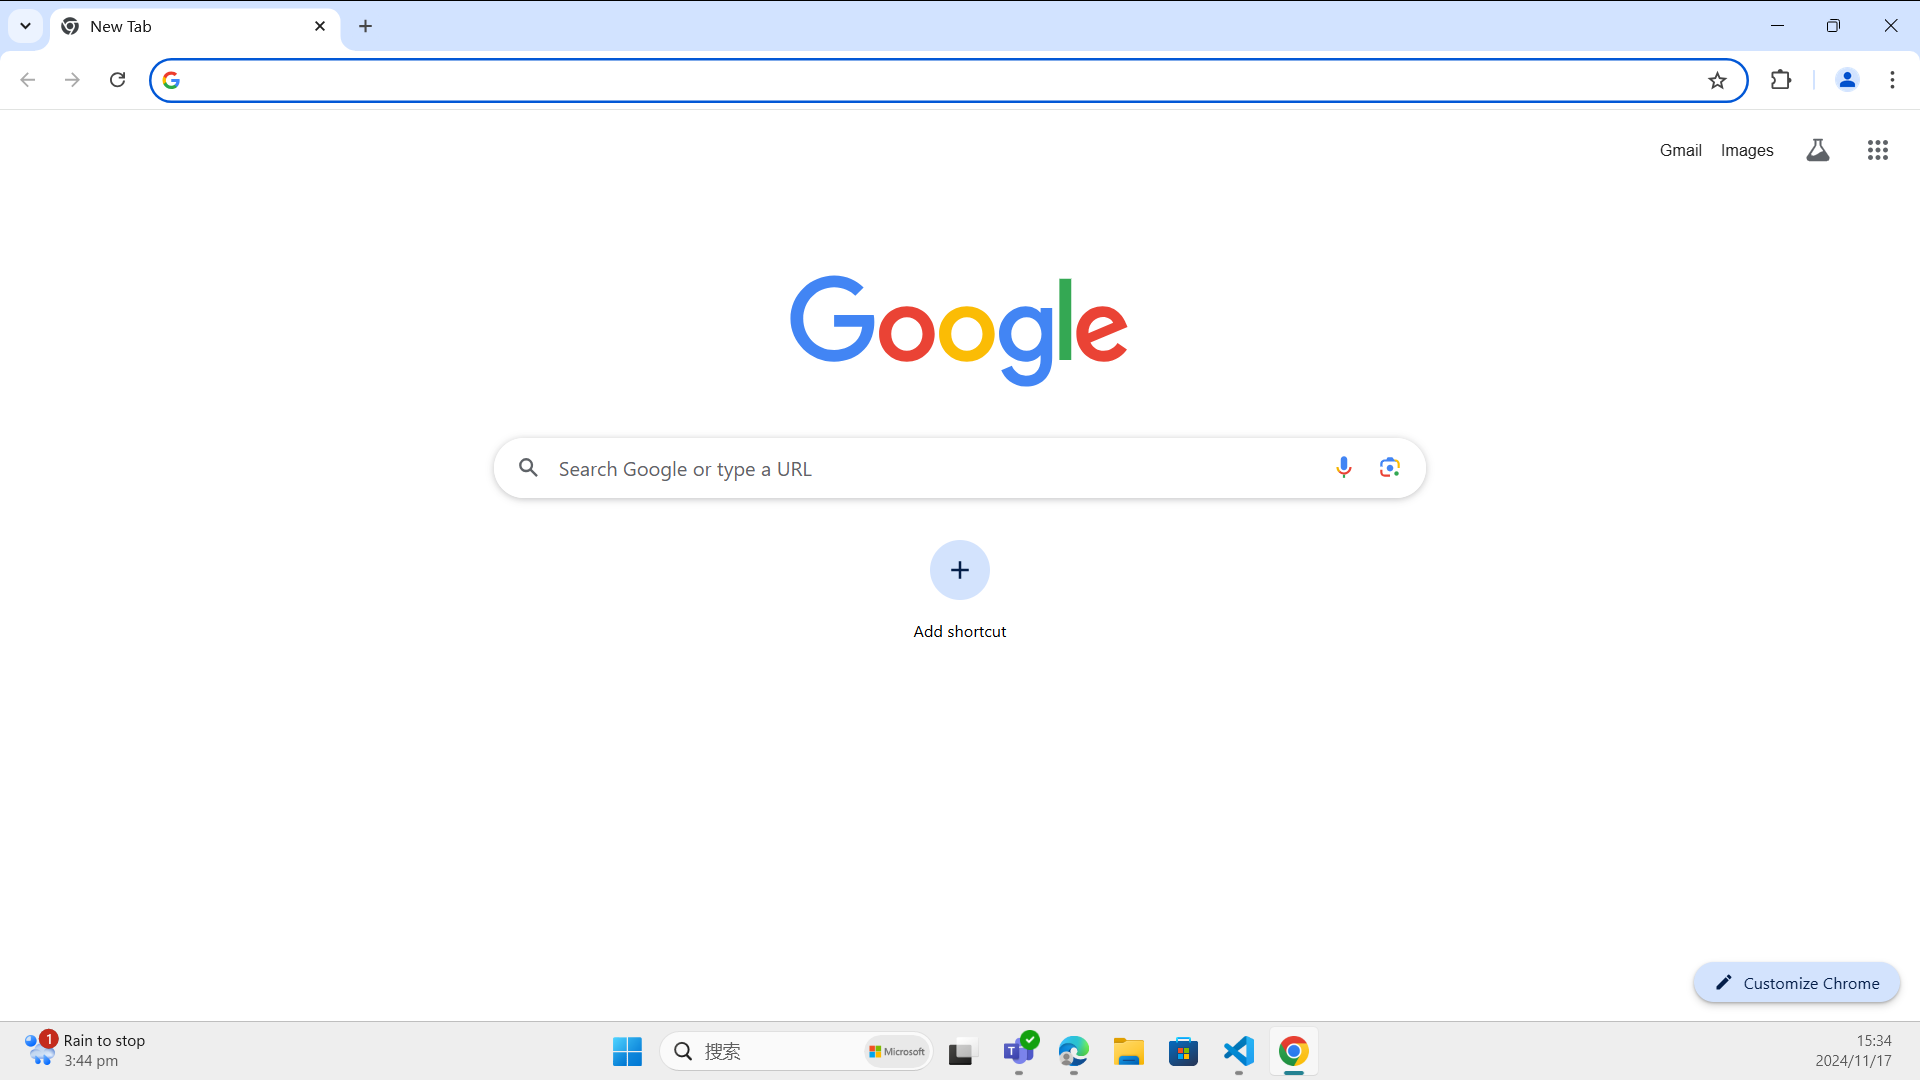

(b) By applying UI-graph, UI Component number: 167


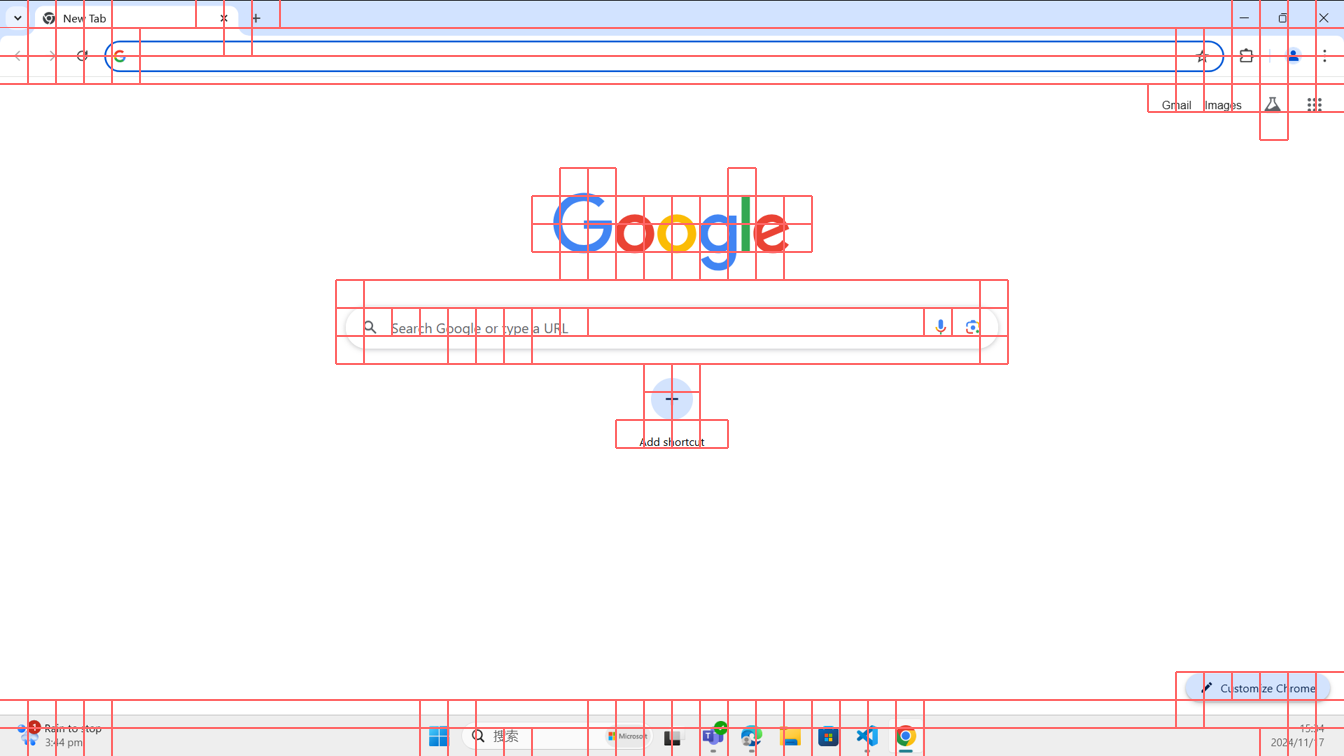

(c) Model output with skip ratio: 0.5
The image shows a screenshot of a web browser, specifically Google Chrome, with the Google logo prominently displayed at the top. The search bar is visible, with the text "Search Google or type a URL" entered. Below the search bar, there is a button labeled "Add shortcut," which is typically used to create a quick access shortcut to a specific Google search result or website. The browser's taskbar at the bottom shows the Google Chrome logo and the time "3:44 pm" along with the date "2011/11." The taskbar also includes a notification icon and a menu icon.<|im_end|>


In [8]:
img_url = 'examples/chrome.png'
vis_dir = 'examples'

messages = [
    {
        "role": "user",
        "content": [
            {"type": "text", "text": "Please describe this image."},
            {
                "type": "image",
                "image": img_url,
                "min_pixels": min_pixels,
                "max_pixels": max_pixels,
            },
        ],
    }
]

# Preparation for inference
text = processor.apply_chat_template(
    messages, tokenize=False, add_generation_prompt=True,
)
image_inputs, video_inputs = process_vision_info(messages)
inputs = processor(
    text=[text],
    images=image_inputs,
    videos=video_inputs,
    padding=True,
    return_tensors="pt",
    vis_dir=vis_dir, # if provided, will be used to save the visualized img
)

inputs = inputs.to("cuda:0")

generated_ids = model.generate(**inputs, max_new_tokens=4096, do_sample=True)
generated_ids_trimmed = [
    out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
]
output_text = processor.batch_decode(
    generated_ids_trimmed, 
)[0]

print(f"(a) Screenshot patch number: {inputs['patch_assign'].shape[0]}")
display(Image.open(img_url))

print(f"(b) By applying UI-graph, UI Component number: {inputs['patch_assign_len'][0]}")
display(Image.open(f'{vis_dir}/demo.png'))

print(f"(c) Model output with skip ratio: {lm_skip_ratio}")
print(output_text)

### Load AITW Data with Thought

In [13]:
import json
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import display
import os

# ==== Set your JSON file path here ====
json_path = "/home/ruis/code/Adaptive-Agent/data/datasets/AITW/metadata/aitw-hf_train_v2.json"  # <-- Replace with your actual JSON file path

# ==== Load the data ====
with open(json_path, "r", encoding="utf-8") as f:
    data_thought = json.load(f)

all_thoughts = []

# ==== Iterate through each sample ====
for entry in data_thought:
    custom_id = entry.get("custom_id")
    images = entry.get("images", [])
    messages = entry.get("messages", [])

    # Extract user message (task) and assistant message (thought/action)
    user_message = next((m["content"] for m in messages if m["role"] == "user"), "")
    assistant_message = next((m["content"] for m in messages if m["role"] == "assistant"), "")

    # Extract task description from user message
    task = None
    for line in user_message.splitlines():
        if line.startswith("Task:"):
            task = line[len("Task:"):].strip()
            break

    # Extract thought and action from assistant message
    thought = None
    action = None
    if "Thought:" in assistant_message and "Action:" in assistant_message:
        thought = assistant_message.split("Thought:")[1].split("Action:")[0].strip()
        action = assistant_message.split("Action:")[1].strip()

    # ==== Display parsed text content ====
    # print(f"\n=== Sample ID: {custom_id} ===")
    # print(f"Task: {task}")
    # print(f"Thought: {thought}")
    # print(f"Action: {action}")
    all_thoughts.append(thought)
    # break

    # # ==== Display all images ====
    # for image_path in images:
    #     print(f"Displaying image: {image_path}")
    #     image_path = os.path.join()
    #     if os.path.exists(image_path):
    #         img = Image.open(image_path)
    #         plt.figure(figsize=(6, 6))
    #         plt.imshow(img)
    #         plt.axis('off')
    #         plt.title(f"Image: {os.path.basename(image_path)}")
    #         plt.show()
    #     else:
    #         print(f"Image not found: {image_path}")

In [27]:
print(len(all_thoughts))
print(all_thoughts[0])

18941
You clicked on the Google search results to find information about capitals. You intended to learn about the capital of a country but mistakenly searched for Paraguay instead of England. Now, you need to clarify your query in order to find the correct capital city.


In [15]:
import json
import matplotlib.pyplot as plt
from PIL import Image
import os

# === Set your data path and image root path here ===
json_path = "/home/ruis/code/Adaptive-Agent/data/datasets/AITW/metadata/hf_train.json"  # <-- Replace with actual JSON file path
image_root = "/home/ruis/code/Adaptive-Agent/data/datasets/AITW/images"    # <-- Replace with root directory of images

# === Load JSON data ===
with open(json_path, "r", encoding="utf-8") as f:
    data = json.load(f)

In [16]:
len(data)

18941


=== Sample ID: aitw_0 ===
Task: What is the capital of England?
Action Type: click
Touch Position: [0.524, 0.06]
Thought: You clicked on the Google search results to find information about capitals. You intended to learn about the capital of a country but mistakenly searched for Paraguay instead of England. Now, you need to clarify your query in order to find the correct capital city.


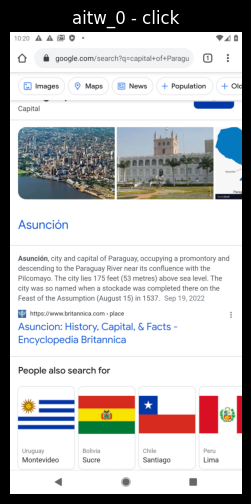


=== Sample ID: aitw_1 ===
Task: What is the capital of England?
Action Type: type
Touch Position: [-1.0, -1.0]
Thought: You type "capital of England" in the search bar to find out its capital.
Typed Text: capital of England


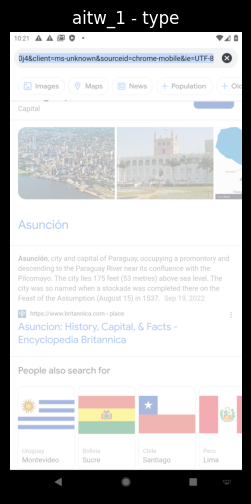

In [17]:
# === Iterate through each item ===
for idx, item in enumerate(data):
    if idx == 2: break
    item_id = item.get("id")
    task = item.get("task")
    domain = item.get("domain")
    image_rel_path = item.get("img_url") + ".png"  # image path is relative and needs .png
    image_full_path = os.path.join(image_root, image_rel_path)

    action_type = item.get("action_type_text")
    touch = item.get("touch", None)
    type_text = item.get("type_text", "")

    thought = all_thoughts[idx]

    # === Display task and action info ===
    print(f"\n=== Sample ID: {item_id} ===")
    print(f"Task: {task}")
    print(f"Action Type: {action_type}")
    print(f"Touch Position: {touch}")
    print(f"Thought: {thought}")
    if action_type.lower() == "type":
        print(f"Typed Text: {type_text}")

    # === Display image if it exists ===
    if os.path.exists(image_full_path):
        img = Image.open(image_full_path)
        plt.figure(figsize=(6, 6))
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"{item_id} - {action_type}")
        plt.show()
    else:
        print(f"Image not found: {image_full_path}")

In [26]:
print(len(data[3]['step_history']))
print(data[4]['task'])

3
What's on the menu at Domino's?


In [5]:
def get_thought_anno(thought_data):
    """
    Build a dict mapping each ep_id to the list of assistant 'Thought:' strings
    in the order they appear in the data.
    
    Args:
        thought_data (list): list of entries, each having an 'images' list
                             and a 'messages' list with assistant content.
    Returns:
        dict: { ep_id (str) : [thought1, thought2, ...], ... }
    """
    ep_thoughts = {}
    
    for entry in thought_data:
        # 1) extract ep_id from the first image path:
        #    e.g. "…/general/14492098987308163042_0.png"
        images = entry.get("images", [])
        if not images:
            continue
        first_img = images[0]
        # filename is after the last '/', then split on '_' to isolate ep_id
        filename = first_img.split("/")[-1]           # "14492098987308163042_0.png"
        ep_id = filename.split("_")[0]                # "14492098987308163042"
        
        # 2) extract assistant message content
        assistant_message = next(
            (m["content"] for m in entry.get("messages", []) if m["role"] == "assistant"),
            ""
        )
        
        # 3) parse out the Thought portion
        thought = None
        if "Thought:" in assistant_message and "Action:" in assistant_message:
            thought = (
                assistant_message
                .split("Thought:")[1]
                .split("Action:")[0]
                .strip()
            )
        
        # 4) accumulate into dictionary
        ep_thoughts.setdefault(ep_id, []).append(thought)
    
    return ep_thoughts

In [7]:
ep_thoughts = get_thought_anno(data_thought)

In [10]:
# print(ep_thoughts['14492098987308163042'])
print(ep_thoughts.keys())
print(ep_thoughts['e7e1616e-dd5f-4eb4-a7f1-b757c7880877-fbfa94eb-b0f2-40b4-a0ec-c95ea564d036.jpg'])

dict_keys(['e7e1616e-dd5f-4eb4-a7f1-b757c7880877-fbfa94eb-b0f2-40b4-a0ec-c95ea564d036.jpg', 'cc174cb2-520d-49c3-93da-f93a1c485c03-48077a71-0bd3-484d-8f19-596861e7e8fb.jpg', 'cc174cb2-520d-49c3-93da-f93a1c485c03-77d2fade-b9c9-46c2-b41b-81e8bc671d15.jpg', 'cc174cb2-520d-49c3-93da-f93a1c485c03-5df6fedf-afb3-4095-b06a-c9a3317e485a.jpg', 'cc174cb2-520d-49c3-93da-f93a1c485c03-9fd3a843-608c-4ab6-9bd2-3adee3a14559.jpg', 'cc174cb2-520d-49c3-93da-f93a1c485c03-dde39bfa-ddfb-4dab-91e3-1f242a32d253.jpg', 'c95ac388-3fea-457d-bb5d-fede3785c6f6-dcdc1299-4778-4bab-934b-25b7f85f4e65.jpg', 'c95ac388-3fea-457d-bb5d-fede3785c6f6-90c6af14-70ab-4b7d-962e-c01741f97a29.jpg', 'c95ac388-3fea-457d-bb5d-fede3785c6f6-e4e44d28-113f-4bfb-b728-767731f4cab0.jpg', 'd9c160e7-b179-4d42-8570-e6f3f85aa412-c05241f0-b26e-40df-b388-6067f69ff404.jpg', 'd9c160e7-b179-4d42-8570-e6f3f85aa412-a4b6efac-e32f-478c-9177-28e49d7ac7de.jpg', 'd9c160e7-b179-4d42-8570-e6f3f85aa412-503a5c81-6a8a-4ece-9c8a-c80d7198f388.jpg', 'd9c160e7-b179-4d

#### Mind2Web

In [ ]:
import json
import matplotlib.pyplot as plt
from PIL import Image
import os
from IPython.display import display

# === Set your data path and image root path here ===
json_path = "/home/t-rsun/code/Adaptive-Multimodal-Agent/data/datasets/Mind2Web/metadata/hf_train.json"  # <-- Replace with actual JSON file path
image_root = "/home/t-rsun/code/Adaptive-Multimodal-Agent/data/datasets/Mind2Web/images"    # <-- Replace with root directory of images

# === Load JSON data ===
with open(json_path, "r", encoding="utf-8") as f:
    mind2web_data = json.load(f)


# ==== Set your JSON file path here ====
json_path = "/home/t-rsun/code/Adaptive-Multimodal-Agent/data/datasets/Mind2Web/metadata/mind2web-hf_train_cot.json"  # <-- Replace with your actual JSON file path

# ==== Load the data ====
with open(json_path, "r", encoding="utf-8") as f:
    data_thought = json.load(f)

all_thoughts = []

# ==== Iterate through each sample ====
for entry in data_thought:
    custom_id = entry.get("custom_id")
    images = entry.get("images", [])
    messages = entry.get("messages", [])

    # Extract user message (task) and assistant message (thought/action)
    user_message = next((m["content"] for m in messages if m["role"] == "user"), "")
    assistant_message = next((m["content"] for m in messages if m["role"] == "assistant"), "")

    # Extract task description from user message
    task = None
    for line in user_message.splitlines():
        if line.startswith("Task:"):
            task = line[len("Task:"):].strip()
            break

    # Extract thought and action from assistant message
    thought = None
    action = None
    if "Thought:" in assistant_message and "Action:" in assistant_message:
        thought = assistant_message.split("Thought:")[1].split("Action:")[0].strip()
        action = assistant_message.split("Action:")[1].strip()

    # ==== Display parsed text content ====
    # print(f"\n=== Sample ID: {custom_id} ===")
    # print(f"Task: {task}")
    # print(f"Thought: {thought}")
    # print(f"Action: {action}")
    all_thoughts.append(thought)
    
ep_thoughts = get_thought_anno(all_thoughts)

AttributeError: 'str' object has no attribute 'get'

In [ ]:
import os
import json
import matplotlib.pyplot as plt
from PIL import Image

# === Iterate through each item using enumerate ===
for idx, item in enumerate(mind2web_data):
    if idx == 2:
        break

    # --- Basic metadata ---
    item_id = item.get("id")
    task = item.get("task")
    domain = item.get("domain")

    # --- Construct full image path (img_url already ends in .jpg) ---
    image_rel = item.get("img_url")
    image_full_path = os.path.join(image_root, image_rel)

    # --- Extract action info from 'step' field ---
    step = item.get("step", {})
    op_info = step.get("operation", {})
    action_type = op_info.get("op")

    # --- Compute touch position as center of bbox, scaled 0–1 ---
    bbox = step.get("bbox", {})
    img_w, img_h = item.get("img_size", [1, 1])
    x_center = (bbox.get("x", 0) + bbox.get("width", 0) / 2) / img_w
    y_center = (bbox.get("y", 0) + bbox.get("height", 0) / 2) / img_h
    touch = [round(x_center, 3), round(y_center, 3)]

    # --- If it's a TYPE action, get the typed text ---
    type_text = op_info.get("value", "") if action_type == "TYPE" else ""

    # --- Retrieve corresponding thought ---
    thought = all_thoughts[idx]

    # === Display task and action info ===
    print(f"\n=== Sample ID: {item_id} ===")
    print(f"Task: {task}")
    print(f"Action Type: {action_type}")
    print(f"Touch Position: {touch}")
    if action_type == "TYPE":
        print(f"Typed Text: {type_text}")
    print(f"Thought: {thought}")

    # === Display image if it exists ===
    if os.path.exists(image_full_path):
        img = Image.open(image_full_path)
        plt.figure(figsize=(6, 6))
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"{item_id} | {action_type}")
        plt.show()
    else:
        print(f"Image not found: {image_full_path}")

## Mind2Web Vis

In [11]:
import json
import matplotlib.pyplot as plt
from PIL import Image
import os
from IPython.display import display

# === Set your data path and image root path here ===
json_path = "/home/t-rsun/code/Adaptive-Multimodal-Agent/data/datasets/Mind2Web/metadata/hf_train.json"  # <-- Replace with actual JSON file path
image_root = "/home/t-rsun/code/Adaptive-Multimodal-Agent/data/datasets/Mind2Web/images"    # <-- Replace with root directory of images

# === Load JSON data ===
with open(json_path, "r", encoding="utf-8") as f:
    mind2web_data = json.load(f)


=== Sample ID: mind2web_0 ===
Task: Look up the scores for the previous day's NBA games
Action Type: CLICK
Touch Position (norm): [0.163, 0.122]


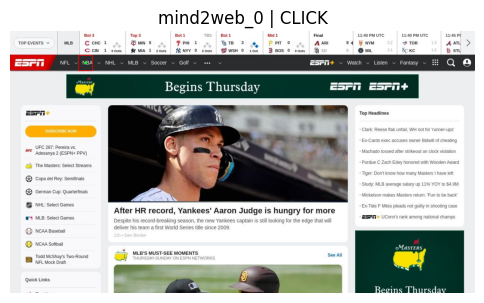


=== Sample ID: mind2web_1 ===
Task: Look up the scores for the previous day's NBA games
Action Type: CLICK
Touch Position (norm): [0.234, 0.247]


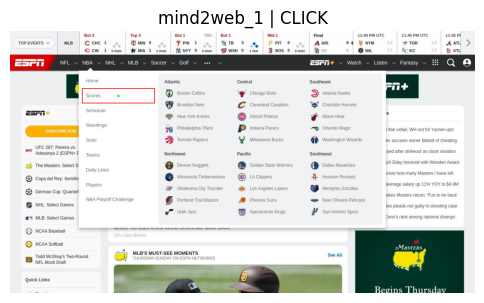

In [13]:
import os
import json
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

# === Iterate through each item using enumerate ===
for idx, item in enumerate(mind2web_data):
    if idx == 2:                      # demo: only show two samples
        break

    # ---------- Basic metadata ----------
    item_id  = item.get("id")
    task     = item.get("task")
    domain   = item.get("domain")

    # ---------- Resolve full image path ----------
    image_rel       = item.get("img_url")            # already ends in .jpg
    image_full_path = os.path.join(image_root, image_rel)

    # ---------- Action information ----------
    step        = item.get("step", {})
    op_info     = step.get("operation", {})
    action_type = op_info.get("op", "")

    # ---------- Bounding-box & center ----------
    bbox   = step.get("bbox", {})
    img_w, img_h = item.get("img_size", [1, 1])

    # center (normalized 0-1) for later use
    x_center = (bbox.get("x", 0) + bbox.get("width", 0)  / 2) / img_w
    y_center = (bbox.get("y", 0) + bbox.get("height", 0) / 2) / img_h
    touch    = [round(x_center, 3), round(y_center, 3)]

    # text to type, if any
    type_text = op_info.get("value", "") if action_type == "TYPE" else ""

    # ---------- Print basic info ----------
    print(f"\n=== Sample ID: {item_id} ===")
    print(f"Task: {task}")
    print(f"Action Type: {action_type}")
    print(f"Touch Position (norm): {touch}")
    if action_type == "TYPE":
        print(f"Typed Text: {type_text}")
    # print(f"Thought: {thought}")      # uncomment if you keep thoughts list

    # ---------- Display image with bounding box ----------
    if os.path.exists(image_full_path):
        img = Image.open(image_full_path).convert("RGB")
        draw = ImageDraw.Draw(img)

        # compute rectangle corners
        x1 = bbox.get("x", 0)
        y1 = bbox.get("y", 0)
        x2 = x1 + bbox.get("width", 0)
        y2 = y1 + bbox.get("height", 0)

        # draw rectangle (red) and center (green)
        draw.rectangle([(x1, y1), (x2, y2)], outline=(255, 0, 0), width=2)
        cx = (x1 + x2) / 2
        cy = (y1 + y2) / 2
        r  = 3
        draw.ellipse([(cx - r, cy - r), (cx + r, cy + r)], fill=(0, 255, 0))

        # show image
        plt.figure(figsize=(6, 6))
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"{item_id} | {action_type}")
        plt.show()
    else:
        print(f"Image not found: {image_full_path}")


In [2]:
import json
import matplotlib.pyplot as plt
from PIL import Image
import os
from IPython.display import display

# === Set your data path and image root path here ===
json_path = "/home/t-rsun/code/Adaptive-Multimodal-Agent/data/datasets/Mind2Web/metadata/hf_test_full.json"  # <-- Replace with actual JSON file path
image_root = "/home/t-rsun/code/Adaptive-Multimodal-Agent/data/datasets/Mind2Web/images"    # <-- Replace with root directory of images

# === Load JSON data ===
with open(json_path, "r", encoding="utf-8") as f:
    mind2web_test_data = json.load(f)

In [7]:
print(mind2web_test_data[1]['split'])
print(len(mind2web_test_data))

test_task
9268


In [9]:
website = []
task = []
domain = []

for i in mind2web_test_data:
    if i['split'] == 'test_website':
        website.append(i)
    if i['split'] == 'test_task':
        task.append(i)
    if i['split'] == 'test_domain':
        domain.append(i)
print(len(website))
print(len(task))
print(len(domain))
print(len(website) + len(task) + len(domain))

1371
2080
5817
9268


In [1]:
import requests
from azure.identity import AzureCliCredential, get_bearer_token_provider

# Get access token
scope = "api://trapi/.default"
credential = get_bearer_token_provider(AzureCliCredential(), scope)
token = credential()

# Set up request
url = "https://trapi.research.microsoft.com/tmds/deployments"
headers = {
    "Authorization": f"Bearer {token}"
}

# Make request
response = requests.get(url, headers=headers)
for line in response.iter_lines():
    print(line.decode('utf-8'))

[
  {
    "name": "Batch Processor API",
    "urlSuffix": "batch",
    "apiId": "batch-processor-api"
  },
  {
    "name": "Future Experiences (FX-1) (OAuth)",
    "urlSuffix": "futureexperiences/fx-1/openai",
    "apiId": "67f073864470616c70bfe8cc"
  },
  {
    "name": "GCR Members - Preview - PTU",
    "urlSuffix": "gcr/preview/openai",
    "apiId": "68268cd6da17ae755758b29c;rev=1"
  },
  {
    "name": "GCR Members - Preview - PTU",
    "urlSuffix": "gcr/preview/openai",
    "apiId": "68268cd6da17ae755758b29c"
  },
  {
    "name": "GCR Members - Shared AOAI (OAuth)",
    "urlSuffix": "gcr/shared/openai",
    "apiId": "66b113a3ec1bc4460812c2d2;rev=1"
  },
  {
    "name": "GCR Members - Shared AOAI (OAuth)",
    "urlSuffix": "gcr/shared/openai",
    "apiId": "66b113a3ec1bc4460812c2d2"
  },
  {
    "name": "GCR_Members - databricks-dbrx-instruct",
    "urlSuffix": "gcr/shared/databricks/deployments/databricks/dbrx-instruct",
    "apiId": "67f938c41812dbb2725bcb15"
  },
  {
    "name": "

In [1]:
# Required packages
from openai import AzureOpenAI
from azure.identity import ChainedTokenCredential, AzureCliCredential, ManagedIdentityCredential, get_bearer_token_provider

#Authenticate by trying az login first, then a managed identity, if one exists on the system)
scope = "api://trapi/.default"
credential = get_bearer_token_provider(ChainedTokenCredential(
    AzureCliCredential(),
    ManagedIdentityCredential(),
), scope)

api_version = '2024-12-01-preview'  # Ensure this is a valid API version see: https://learn.microsoft.com/en-us/azure/ai-services/openai/api-version-deprecation#latest-ga-api-release
deployment_name = 'gpt-4o_2024-05-13'  # Ensure this is a valid deployment name see https://aka.ms/trapi/models for the deployment name
instance = 'gcr/preview' # See https://aka.ms/trapi/models for the instance name
endpoint = f'https://trapi.research.microsoft.com/{instance}'

#Create an AzureOpenAI Client
client = AzureOpenAI(
    azure_endpoint=endpoint,
    azure_ad_token_provider=credential,
    api_version=api_version,
)

#Do a chat completion and capture the response
response = client.chat.completions.create(
    model=deployment_name,
    messages=[
        {
            "role": "user",
            "content": "Give a one word answer, what is the capital of France?",
        },
    ]
)

#Parse out the message and print
response_content = response.choices[0].message.content
print(response_content)

Paris


What can I do in this website?
